In [2]:
from collections import defaultdict

import matplotlib.pyplot as plt

# import norse
import numpy as np
import tonic
import torch
import tqdm
from spinnaker2 import brian2_sim, hardware, s2_nir, snn

import nir

class Args(object):
    pass
args = Args()


### Select to run either on Brian2 or on SpiNNaker2.

In [3]:
args.s2_ip = "brian2"        # use Brian2 Simulator
#args.s2_ip = "192.168.1.48"  # enter the IP of the SpiNNaker2 board

In [4]:
args.s2_ip

'brian2'

Load the NIR graph.

In [5]:
nir_graph = nir.read("cnn_sinabs.nir")
nlist = (
    [
        "input",
    ]
    + [str(i) for i in range(13)]
    + [
        "output",
    ]
)
n = nir_graph.nodes

s2_nir.model_summary(nir_graph)

input <class 'nir.ir.Input'> {'input': array([ 2, 34, 34])} {'output': array([ 2, 34, 34])} -> ['0']
0 <class 'nir.ir.Conv2d'> {'input': array([ 2, 34, 34])} {'output': array([16, 16, 16])} -> ['1']
1 <class 'nir.ir.IF'> {'input': array([16, 16, 16])} {'output': array([16, 16, 16])} -> ['2']
2 <class 'nir.ir.Conv2d'> {'input': array([16, 16, 16])} {'output': array([16, 16, 16])} -> ['3']
3 <class 'nir.ir.IF'> {'input': array([16, 16, 16])} {'output': array([16, 16, 16])} -> ['4']
4 <class 'nir.ir.SumPool2d'> {'input': None} {'output': None} -> ['5']
5 <class 'nir.ir.Conv2d'> {'input': array([16,  8,  8])} {'output': array([8, 8, 8])} -> ['6']
6 <class 'nir.ir.IF'> {'input': array([8, 8, 8])} {'output': array([8, 8, 8])} -> ['7']
7 <class 'nir.ir.SumPool2d'> {'input': None} {'output': None} -> ['8']
8 <class 'nir.ir.Flatten'> {'input': array([8, 4, 4])} {'output': array([ 8, 16])} -> ['9']
9 <class 'nir.ir.Affine'> {'input': array([128])} {'output': array([256])} -> ['10']
10 <class 'ni

Infer input and output types for each Node in the NIR graph because not all shapes are defined inside the stored graph.

In [6]:
nir_graph.infer_types()

s2_nir.model_summary(nir_graph)

[warning] 4.input_type undefined, set to 3.output_type
[warning] 7.input_type undefined, set to 6.output_type
[warning] overwriting 9.input: [[128]] with 8.output: [[ 8 16]]
input <class 'nir.ir.Input'> {'input': array([ 2, 34, 34])} {'output': array([ 2, 34, 34])} -> ['0']
0 <class 'nir.ir.Conv2d'> {'input': array([ 2, 34, 34])} {'output': array([16, 16, 16])} -> ['1']
1 <class 'nir.ir.IF'> {'input': array([16, 16, 16])} {'output': array([16, 16, 16])} -> ['2']
2 <class 'nir.ir.Conv2d'> {'input': array([16, 16, 16])} {'output': array([16, 16, 16])} -> ['3']
3 <class 'nir.ir.IF'> {'input': array([16, 16, 16])} {'output': array([16, 16, 16])} -> ['4']
4 <class 'nir.ir.SumPool2d'> {'input': array([16, 16, 16])} {'output': array([16,  8,  8])} -> ['5']
5 <class 'nir.ir.Conv2d'> {'input': array([16,  8,  8])} {'output': array([8, 8, 8])} -> ['6']
6 <class 'nir.ir.IF'> {'input': array([8, 8, 8])} {'output': array([8, 8, 8])} -> ['7']
7 <class 'nir.ir.SumPool2d'> {'input': array([8, 8, 8])} 

If you want to record the output of intermediate IF neurons, use `s2_nir.add_output_to_node`. Only do this if you actually want to record because this will slow down the iterations significantly!

In [7]:
# Add an output to neurons of layer '1'
# s2_nir.add_output_to_node('1', nir_graph, '1_out')

Convert the graph from NIR to the py-spinnaker2 framework. Set `outputs` according to whether you would like to record spikes `["spikes"]`, membrane potantials `["v"]` or both `["spikes", "v"]`.

In [8]:
net, inp, outp = s2_nir.from_nir(
    nir_graph,
    outputs=["spikes"],
    discretization_timestep=0.0001,
    conn_delay=0,
    scale_weights=True,
)

Node '0'
Got <class 'nir.ir.Conv2d'>
input:  [('input', <class 'nir.ir.Input'>)]
output:  [('1', <class 'nir.ir.IF'>)]

Node '1'
Got <class 'nir.ir.IF'>
record:  []
[16 16 16] -> [16 16 16]
input:  [('0', <class 'nir.ir.Conv2d'>)]
output:  [('2', <class 'nir.ir.Conv2d'>)]

Node '10'
Got <class 'nir.ir.IF'>
record:  []
[256] -> [256]
input:  [('9', <class 'nir.ir.Affine'>)]
output:  [('11', <class 'nir.ir.Affine'>)]

Node '11'
Got <class 'nir.ir.Affine'>
input:  [('10', <class 'nir.ir.IF'>)]
output:  [('12', <class 'nir.ir.IF'>)]

Node '12'
Got <class 'nir.ir.IF'>
record:  ['spikes']
[10] -> [10]
input:  [('11', <class 'nir.ir.Affine'>)]
output:  [('output', <class 'nir.ir.Output'>)]

Node '2'
Got <class 'nir.ir.Conv2d'>
input:  [('1', <class 'nir.ir.IF'>)]
output:  [('3', <class 'nir.ir.IF'>)]

Node '3'
Got <class 'nir.ir.IF'>
record:  []
[16 16 16] -> [16 16 16]
input:  [('2', <class 'nir.ir.Conv2d'>)]
output:  [('4', <class 'nir.ir.SumPool2d'>)]

Node '4'
Got <class 'nir.ir.SumPool2d

1->3: Conv2d
{'in_height': 16, 'in_width': 16, 'stride_x': 1, 'stride_y': 1, 'pool_x': 1, 'pool_y': 1, 'pad_top': 1, 'pad_bottom': 1, 'pad_left': 1, 'pad_right': 1} weights:  (16, 16, 3, 3)
3->6: SumPool2d->Conv2d
{'in_height': 8, 'in_width': 8, 'stride_x': 1, 'stride_y': 1, 'pool_x': 1, 'pool_y': 1, 'pad_top': 1, 'pad_bottom': 1, 'pad_left': 1, 'pad_right': 1} weights:  (16, 8, 3, 3)
SumPool2d(kernel_size=array([2, 2]), stride=array([2, 2]), padding=array([0, 0]))
['Projection_0', 'Projection_1', 'Projection_2', 'Projection_3', 'Projection_4']


Because of memory and compute time limitations per core, we need to reduce the number of neurons per core for some of the neuron populations:

In [9]:
max_atoms_per_core = {
    "3": 256,
    "6": 128,
    "10": 16
}
for pop in net.populations:
    if pop.name in max_atoms_per_core.keys():
        pop.set_max_atoms_per_core(max_atoms_per_core[pop.name])

This just prints the population and projection sizes.

In [10]:
pop_order = [5, 0, 3, 4, 1, 2]
proj_order = [1, 0, 2, 3, 4]
print("\nPopulation sizes:")
for pop_id in pop_order:
    pop = net.populations[pop_id]
    print(f"{pop.name}: {pop.size}")
print("\nProjection sizes:")
for proj_id in proj_order:
    proj = net.projections[proj_id]
    if isinstance(proj, snn.Projection):
        print(
            f"{proj.pre.name} -> {proj.post.name}: {proj.sparse_weights.nonzero()[0].shape[0]}"
        )
    elif isinstance(proj, snn.Conv2DProjection):
        print(f"{proj.pre.name} -> {proj.post.name}: {proj.weights.shape}")


Population sizes:
input: 2312
1: 4096
3: 4096
6: 512
10: 256
12: 10

Projection sizes:
input -> 1: (2, 16, 5, 5)
10 -> 12: 2560
6 -> 10: 131072
1 -> 3: (16, 16, 3, 3)
3 -> 6: (16, 8, 3, 3)


# Evaluation on NMNIST
Load the dataset

In [11]:
to_frame = tonic.transforms.ToFrame(
    sensor_size=tonic.datasets.NMNIST.sensor_size, time_window=1e3
)
dataset = tonic.datasets.NMNIST(".", transform=to_frame, train=False)
loader = torch.utils.data.DataLoader(
    dataset,
    shuffle=True,
    batch_size=1,
    collate_fn=tonic.collation.PadTensors(batch_first=False),
)

We define a method to reshape the input into the required input format (spike lists).

In [12]:
def convert_input(x):
    print(x.shape)
    d = {}
    # T = x.shape[0]
    C = x.shape[2]
    H = x.shape[3]
    W = x.shape[4]
    for c in range(C):
        for h in range(H):
            for w in range(W):
                d[c * H * W + h * W + w] = x[:, 0, c, h, w].nonzero()[0].tolist()
    return d

This is how we evaluate one single sample:

In [13]:
def evaluate(hw, net, inp, outp, x, y):
    input_spikes = convert_input(x)
    inp[0].params = input_spikes

    timesteps = x.shape[0] + 1
    net.reset()
    hw.run(net, timesteps, sys_tick_in_s=2.5e-3, debug=False)

    out_spikes = np.zeros(10)
    out_spike_times = outp[0].get_spikes()
    for idx, spikes in out_spike_times.items():
        # we are interested in spike rate, not count or exact times
        out_spikes[idx] = len(spikes) / x.shape[0]
    return np.argmax(out_spikes)

If we use Brian2, we can now create the Backend, for SpiNNaker2 we have to do this for each iteration.

In [14]:
use_brian2 = args.s2_ip is None or args.s2_ip=="brian2"
if use_brian2:
    # brian2 backend can be reused
    hw = brian2_sim.Brian2Backend()
    print("\nUsing brian2 simulator!")
else:
     # S2 Hardware has to be created for each sample processed -> in loop
    print(f"\nUsing SpiNNaker2 at IP {args.s2_ip}")


Using brian2 simulator!


Iterate over the complete dataset. Warning: This will usually take several hours!

In [15]:
predicted_spike = []
groundtruth = []
import sys
with torch.no_grad():
    for batch in tqdm.tqdm(loader, file=sys.stdout):
        x, y = batch
        x = x.detach().numpy()
        y = y.detach().numpy()
        print(" ")
        # We have to create S2 Chip connection
        if not use_brian2:
            hw = hardware.SpiNNaker2Chip(eth_ip=args.s2_ip)  # use ethernet
        pred_spike = evaluate(hw, net, inp, outp, x, y)

        # If we are using SpiNNaker2 chip, we have to delete the connection after use
        if not use_brian2:
            del hw
        predicted_spike.append(pred_spike)
        groundtruth.append(y[0])
        accuracy_spike = np.mean(np.array(predicted_spike) == np.array(groundtruth))
        print(f"Prediction:{pred_spike}, ground truth: {y[0]}")
        print(
            f"Current accuracy: {accuracy_spike:.4f}"
        )
print("\nFinished!\n")

final_accuracy = np.mean(np.array(predicted_spike) == np.array(groundtruth))

print(f"\nFinal accuracy: {final_accuracy:.4f}")
acc_file = "s2_brian2_accuracy.npy" if use_brian2 else "s2_accuracy.npy"
np.save(acc_file, final_accuracy)

  0%|          | 0/10000 [00:00<?, ?it/s] 
(309, 1, 2, 34, 34)


WARNING    /home/jobst/anaconda3/envs/nir/lib/python3.11/site-packages/brian2/units/fundamentalunits.py:1561: RuntimeWarning: divide by zero encountered in divide
  result = operation(self_arr, other_arr)
 [py.warnings]


(2, 16, 5, 5)
(16, 16, 3, 3)
(16, 8, 3, 3)
Starting simulation at t=0. s for a duration of 310. ms
310. ms (100%) simulated in < 1s
finished run
getting spikes from  12
Prediction:1, ground truth: 1
Current accuracy: 1.0000
  0%|          | 1/10000 [00:04<12:46:46,  4.60s/it] 
(299, 1, 2, 34, 34)
Starting simulation at t=0. s for a duration of 300. ms
300. ms (100%) simulated in < 1s
finished run
getting spikes from  12
Prediction:9, ground truth: 8
Current accuracy: 0.5000
  0%|          | 2/10000 [00:06<7:47:21,  2.80s/it]  
(308, 1, 2, 34, 34)
Starting simulation at t=0. s for a duration of 309. ms
309. ms (100%) simulated in < 1s
finished run
getting spikes from  12
Prediction:3, ground truth: 3
Current accuracy: 0.6667
  0%|          | 3/10000 [00:07<6:25:30,  2.31s/it] 
(301, 1, 2, 34, 34)
Starting simulation at t=0. s for a duration of 302. ms
302. ms (100%) simulated in < 1s
finished run
getting spikes from  12
Prediction:6, ground truth: 6
Current accuracy: 0.7500
  0%|       

KeyboardInterrupt: 

## Activity
Now we want to get the activity output of the first IF layer, using a smaller dataset. In order to be able to extract the activity, we need to add the output to the net first.

We could use:
```
s2_nir.add_output_to_node('1', nir_graph, '1_out')
```
But then we would have to do a few of the other steps again. Instead, let us just modify the already converted net


In [15]:
outp = None
for pop in net.populations:
    if pop.name == "1":
        pop.record = ["v", "spikes"]
        outp = [pop]
        break
print("outp", outp[0].name, outp[0].record)

outp 1 ['v', 'spikes']


Load the new data.

In [16]:
data = np.load("cnn_numbers.npy")
count = data.shape[1]
timesteps = data.shape[0]

In [17]:
def evaluate(hw, net, inp, outp, x):
    input_spikes = convert_input(x)
    inp[0].params = input_spikes

    timesteps = x.shape[0] + 1
    net.reset()
    hw.run(net, timesteps, sys_tick_in_s=2.5e-3, debug=False)

    out_spike_times = outp[0].get_spikes()
    out_spikes = np.zeros((301, len(out_spike_times)))
    for idx, spikes in out_spike_times.items():
        # we are interested in spike rate, not count or exact times
        out_spikes[spikes, idx] = 1
        
    out_spikes = out_spikes.reshape((301,1,16,16,16))
    return out_spikes
    


In [25]:
all_spikes = np.zeros((301,10,16,16,16))
for i in range(count):
    x = data[:,i:i+1,...]
    
    if not use_brian2:
        hw = hardware.SpiNNaker2Chip(eth_ip=args.s2_ip)  # use ethernet
    
    pred_spike = evaluate(hw, net, inp, outp, x)

    # If we are using SpiNNaker2 chip, we have to delete the connection after use
    if not use_brian2:
        del hw
    all_spikes[:,i:i+1,...] = pred_spike

sim_name = "s2_brian2" if use_brian2 else "s2"
np.save(f"{sim_name}_corrected_activity.npy", all_spikes[1:,...])
np.save(f"{sim_name}_uncorrected_activity.npy", all_spikes[:-1,...])


(300, 1, 2, 34, 34)
timesteps:  300
outp 1 ['v', 'spikes']
Starting simulation at t=0. s for a duration of 301. ms
301. ms (100%) simulated in < 1s
finished run
getting spikes from  1
getting spikes from  12
getting volatges from  1
{0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: [], 11: [], 12: [], 13: [], 14: [], 15: [], 16: [], 17: [], 18: [], 19: [], 20: [], 21: [], 22: [], 23: [], 24: [], 25: [], 26: [], 27: [], 28: [], 29: [], 30: [], 31: [], 32: [], 33: [], 34: [], 35: [], 36: [], 37: [], 38: [], 39: [], 40: [], 41: [178], 42: [229], 43: [], 44: [], 45: [], 46: [], 47: [], 48: [], 49: [], 50: [], 51: [], 52: [], 53: [], 54: [], 55: [], 56: [], 57: [], 58: [], 59: [], 60: [], 61: [], 62: [], 63: [], 64: [], 65: [], 66: [], 67: [], 68: [], 69: [], 70: [24, 41], 71: [], 72: [], 73: [], 74: [], 75: [169, 174], 76: [224], 77: [], 78: [], 79: [], 80: [], 81: [], 82: [], 83: [], 84: [], 85: [37], 86: [23, 43, 50], 87: [16, 23, 28, 35, 70, 152], 88: [15, 23, 2

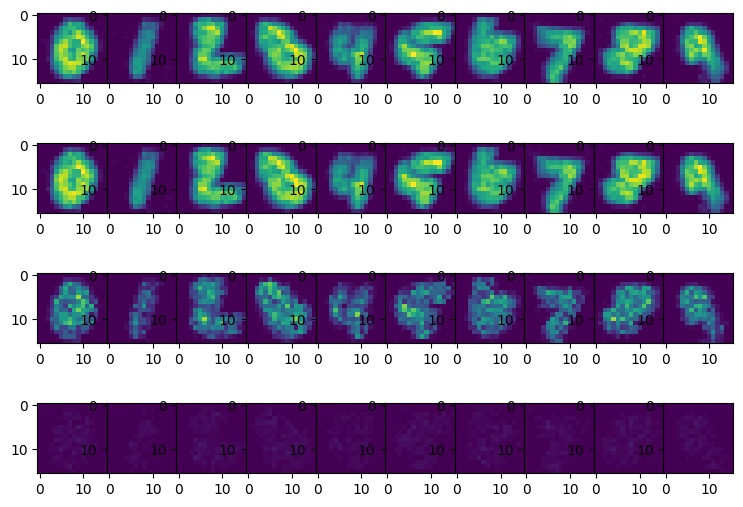

In [24]:
plt.ion()
fig, axs = plt.subplots(4,10)
norse_spikes = np.load("Norse_activity.npy")

s2 = np.mean(all_spikes[1:,...], axis=0)
s2 = np.mean(s2, axis=1)
n = np.mean(norse_spikes, axis=0)
n = np.mean(n, axis=1)
d = np.mean(np.abs(norse_spikes-all_spikes[1:,...]), axis=0)
d = np.mean(d, axis=1)
d2 = np.abs(s2-n)


for idx in range(10):
    axs[0, idx].imshow(s2[idx,...], vmin=0, vmax=0.017)
    axs[1, idx].imshow(n[idx,...], vmin=0, vmax=0.017)
    axs[2, idx].imshow(d[idx,...], vmin=0, vmax=0.017)
    axs[3, idx].imshow(d2[idx,...], vmin=0, vmax=0.017)

plt.tight_layout(pad=-3, h_pad=-2,w_pad=-2)